# How to Add Semantic Search to Agent's Memory

- Author: [leebeanbin](https://github.com/leebeanbin)
- Peer Review: [Jiwon Kim](https://github.com/brain604), [ByungGil Yoon](https://github.com/acho98)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/16-Evaluations/02-Evaluation-using-RAGAS.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/16-Evaluations/02-Evaluation-using-RAGAS.ipynb)


## Overview
A guide on implementing `Semantic Search` in LangGraph memory systems, offering a different approach to memory management that enables context-aware and similarity-based retrieval.

## Memory Management Approaches in LangGraph

### Different Memory Systems
- `Checkpointing`: State persistence with thread management
- `Summarization`: Compression of long conversations
- `Semantic Search`: Vector-based similarity retrieval
- Note: Each system serves different use cases and requirements

### Semantic Search Characteristics
- Vector-based memory retrieval
- Natural language querying
- Contextual understanding
- Similarity-based matching

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [What is Sementic Search?](#what-is-semantic-search)
- [Advanced Memory Features](#advanced-memory-features)
- [Using Semantic Search in Agents](#using-semantic-search-in-agents)
- [Key Differences Between Basic Search and Semantic Search](#key-differences-between-basic-search-and-semantic-search)

### References

- [Memory in LangGraph](https://langchain-ai.github.io/langgraph/concepts/memory/#editing-message-lists)
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/how-tos/memory/semantic-search/)
- [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.PutOp.index)

----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_openai",
        "langchain_community",
        "langgraph"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [ ]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "LLM-as-Judge",
    }
)

In [3]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## What is Semantic Search?

`Semantic search` is a method that retrieves data based on its meaning and context, rather than just matching keywords. It uses vector embeddings to represent data and calculates relevance through mathematical techniques like cosine similarity.

### Comparison : Basic Memory Search vs. Semantic Search

#### Basic Memory Search

In [52]:
# Basic memory search
memories = {
    "1": "I love machine learning",
    "2": "Neural networks are fascinating",
    "3": "I enjoy programming in Python",
    "4": "Data science is my passion",
}

# Simple keyword-based search
query = "machine learning"
results = [value for key, value in memories.items() if query in value]

# Output
for result in results:
    print(f"Memory: {result}")

Memory: I love machine learning


`Basic Memory Search` returns data only if the query string "machine learning" is exactly present in the stored memory.
The search fails if the query slightly differs from the stored text, even if the context is related.

### Sementic Search

#### Basic Memory Configuration  

To enable `Semantic Search`, we need to create a store with index configuration. The store will use embeddings to convert text into vectors for similarity searching.

[Note] 
The `init_embeddings` function is currently in beta and its API may change. For production use, consider using stable embedding models or monitor API changes.


In [4]:
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

# Initialize embeddings model
embeddings = init_embeddings("openai:text-embedding-3-small")

/var/folders/cg/xhv549ln7db228ly_v8l67t00000gn/T/ipykernel_10229/3437837375.py:5: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  embeddings = init_embeddings("openai:text-embedding-3-small")


Alternatively, you can use other embedding models:

In [ ]:
# Option 1: Using OpenAI embeddings directly
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

# Option 2: Using HuggingFace embeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()

After setting up embeddings, create the store with `Semantic Search` enabled:

In [5]:
# Create store with semantic search enabled
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
    }
)

#### Creating and Searching Memories

Let's store some example memories and see how `Semantic Search` works:

In [6]:
# Store test memories
store.put(("user_123", "memories"), "1", {"text": "I love machine learning"})
store.put(("user_123", "memories"), "2", {"text": "Neural networks are fascinating"})
store.put(("user_123", "memories"), "3", {"text": "I enjoy programming in Python"})
store.put(("user_123", "memories"), "4", {"text": "Data science is my passion"})

Search memories with natural language query:

In [7]:
results = store.search(
    ("user_123", "memories"),
    query="Tell me about AI and ML",
    limit=2
)

# Print results with similarity scores
for memory in results:
    print(f'Memory: {memory.value["text"]} (similarity: {memory.score:.3f})')

Memory: I love machine learning (similarity: 0.509)
Memory: Neural networks are fascinating (similarity: 0.399)


## Advanced Features

### Multi-vector Indexing

You can index different aspects of memories separately:

In [8]:
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore
from typing import List, Dict

def create_embeddings(embedding_model_name: str):
    """Creates the embedding model."""
    return init_embeddings(embedding_model_name)

def create_memory_store(embeddings, dims):
    """Creates a memory store using the provided embeddings and dimensions."""
    return InMemoryStore(index={"embed": embeddings, "dims": dims})

def store_memories(store: InMemoryStore, user_id: str, memories: List[Dict[str, str]]) -> InMemoryStore:
    """Stores multiple memories, recreating the store each time (for immutability)."""
    for i, memory in enumerate(memories):
        store.put((user_id, "memories"), f"mem{i+1}", memory)
    return store # No need to copy anymore

def search_memories(store: InMemoryStore, user_id: str, query: str, limit: int = 2) -> List:
    """Searches for semantically similar memories in the memory store."""
    return store.search((user_id, "memories"), query=query, limit=limit)

def format_search_result(result) -> str:
    """Formats a single search result into a readable string."""
    return f"""Content: {result.value['content']}
Context: {result.value['context']}
Similarity Score: {result.score:.3f}
{"-" * 20}"""

def print_search_results(results: List):
    """Prints the search results."""
    print("\n".join(map(format_search_result, results)))

In [9]:
embedding_model_name = "openai:text-embedding-3-small"
embeddings = create_embeddings(embedding_model_name)

# Calculate dimensions ONCE
test_embedding = embeddings.embed_query("test")
dims = len(test_embedding)

memory_store = create_memory_store(embeddings, dims)

mem_data = [
    {"content": "Transformer networks are a powerful architecture for natural language processing.", "context": "Reading about NLP models"},
    {"content": "Recurrent Neural Networks (RNNs) are designed for sequential data like time series.", "context": "Studying deep learning"},
    {"content": "Convolutional Neural Networks (CNNs) excel at image recognition tasks.", "context": "Working on computer vision projects"},
    {"content": "Microservices architecture involves breaking down an application into small, independent services.", "context": "Discussing software design patterns"},
    {"content": "Monolithic architecture is a traditional approach where all components of an application are tightly coupled.", "context": "Learning about software architecture"},
    {"content": "BERT is a transformer-based model used for various NLP tasks.", "context": "Exploring pre-trained language models"},
    {"content": "Fine-tuning BERT for sentiment analysis can improve accuracy.", "context": "Experimenting with NLP fine-tuning"},
    {"content": "Software architecture focuses on the high-level structure and organization of a software system.", "context": "Software engineering course"},
    {"content": "Choosing between monolith and microservices depends on factors like scalability and complexity.", "context": "Team discussion on system design"}
]

In [10]:
memory_store = store_memories(memory_store, "user_123", mem_data)

search_query = "machine learning architectures"
search_results = search_memories(memory_store, "user_123", search_query)
print_search_results(search_results)

Content: Transformer networks are a powerful architecture for natural language processing.
Context: Reading about NLP models
Similarity Score: 0.390
--------------------
Content: Monolithic architecture is a traditional approach where all components of an application are tightly coupled.
Context: Learning about software architecture
Similarity Score: 0.366
--------------------


In [11]:
search_query = "software architecture design"
search_results = search_memories(memory_store, "user_123", search_query)
print_search_results(search_results)

Content: Software architecture focuses on the high-level structure and organization of a software system.
Context: Software engineering course
Similarity Score: 0.531
--------------------
Content: Microservices architecture involves breaking down an application into small, independent services.
Context: Discussing software design patterns
Similarity Score: 0.504
--------------------


## Using Semantic Search in Agents

You can integrate `Semantic Search` into your agents :

In [16]:
from typing import Optional
from langchain.chat_models import init_chat_model
from langgraph.store.base import BaseStore
from langgraph.graph import START, MessagesState, StateGraph 
from langchain_opentutorial.graphs import visualize_graph 

# Initialize the LLM
llm = init_chat_model("openai:gpt-4o-mini")

# Define the agent's behavior
def chat_with_memory(state, *, store: BaseStore):
    # Retrieve relevant memories based on the user's last message
    query = state["messages"][-1].content  # User's latest message
    items = store.search(
        ("user_123", "memories"), query=query, limit=3  # Retrieve top 3 matches
    )

    # Format retrieved memories with error handling
    memories = []
    for item in items:
        try:
            content = item.value['content']
            context = item.value['context']
            memories.append(f"- {content} ({context})")
        except (KeyError, AttributeError):  # Handle potential errors
            print(f"Warning: Error processing memory item: {item}")

    memories_text = f"## Related Memories:\n{''.join(memories)}" if memories else "## No relevant memories found."

    # Log the memories for debugging
    print("Retrieved Memories:")
    print(memories_text)

    # Generate response based on memories and the user's input
    response = llm.invoke(
        [
            {"role": "system", "content": f"You are a helpful assistant.\n{memories_text}"},
            *state["messages"],
        ]
    )
    return {"messages": [response]}


Agent workflow :

[Note] We will use the existing `memory_store data for subsequent examples.

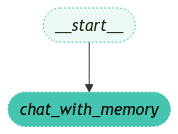

In [17]:
# Build a state graph for the agent
builder = StateGraph(MessagesState)
builder.add_node(chat_with_memory)
builder.add_edge(START, "chat_with_memory")

# Compile the graph with the memory store
agent_graph = builder.compile(store=memory_store)

visualize_graph(agent_graph)

In [18]:
# User initiates a conversation
input_message = {"messages": [{"role": "user", "content": "Tell me more about machine learning architectures."}]}

# Stream agent responses
for message, metadata in agent_graph.stream(
    input=input_message,
    stream_mode="messages",
):
    print(message.content, end="")

Retrieved Memories:
## Related Memories:
- Transformer networks are a powerful architecture for natural language processing. (Reading about NLP models)- Monolithic architecture is a traditional approach where all components of an application are tightly coupled. (Learning about software architecture)- Recurrent Neural Networks (RNNs) are designed for sequential data like time series. (Studying deep learning)
Machine learning architectures refer to the structures and frameworks used to build and organize machine learning models. Different architectures are designed for different types of tasks and data. Here are some key concepts:

1. **Monolithic Architecture**: This is a traditional approach where all components of a machine learning application are tightly coupled into a single unit. While simpler to manage initially, it can become difficult to scale and maintain as the application grows.

2. **Modular Architecture**: In contrast to monolithic systems, modular architecture breaks the

### Using Semantic Search with create_react_agent

Enable `Semantic Search` in your agent by injecting the memory store into the state_modifier. This allows the agent to retrieve semantically relevant memories and include them in its context before responding. Additionally, you can use the store directly within a tool, allowing the agent to manually store or retrieve memories dynamically during conversations.

In [19]:
import uuid
from typing import Optional

from langchain.chat_models import init_chat_model
from langgraph.prebuilt import InjectedStore
from langgraph.store.base import BaseStore
from typing_extensions import Annotated

from langgraph.prebuilt import create_react_agent


def prepare_messages(state, *, store: BaseStore):
    """
    Prepare messages for the LLM by searching memories based on the last user message.
    """
    # Search based on the last user message
    items = store.search(
        ("user_123", "memories"),
        query=state["messages"][-1].content,
        limit=2
    )

    # Combine content and context from retrieved memories
    memories = "\n".join(
        f"- {item.value['content']} (Context: {item.value['context']})"
        for item in items
    )
    memories = f"## Memories of user\n{memories}" if memories else ""

    # Include the retrieved memories as system-level context
    return [
        {"role": "system", "content": f"You are a helpful assistant.\n{memories}"}
    ] + state["messages"]


def upsert_memory(
    content: str,
    context: str,
    *,
    memory_id: Optional[uuid.UUID] = None,
    store: Annotated[BaseStore, InjectedStore],
):
    """
    Upsert a memory into the store.
    """
    mem_id = memory_id or uuid.uuid4()  # Generate a new UUID if not provided
    store.put(
        ("user_123", "memories"),
        key=str(mem_id),
        value={
            "content": content,
            "context": context,
        },
    )
    return f"Stored memory with ID: {mem_id}"


# Initialize the agent
agent = create_react_agent(
    init_chat_model("openai:gpt-4o-mini"),
    tools=[upsert_memory],  # Include the upsert memory tool
    # Prepare messages for the LLM
    state_modifier=prepare_messages,
    store=memory_store,
)

# Example: Simulate a conversation
for message, metadata in agent.stream(
    input={"messages": [{"role": "user", "content": "Tell me about transformer models"}]},
    stream_mode="messages",
):
    print(message.content, end="")

Transformer models are a type of neural network architecture introduced in the paper "Attention is All You Need" by Vaswani et al. in 2017. They have become the foundation for many state-of-the-art natural language processing (NLP) tasks. Here are some key features of transformer models:

1. **Attention Mechanism**: Transformers utilize a mechanism called self-attention that allows the model to weigh the importance of different words in a sentence relative to each other. This enables the model to capture relationships between words regardless of their position in the input sequence.

2. **Architecture**: A transformer model consists of an encoder and a decoder:
   - The **encoder** processes the input data and generates a continuous representation.
   - The **decoder** generates the output sequence based on the encoder's representation.

3. **Parallelization**: Unlike recurrent neural networks (RNNs), which process sequences sequentially, transformers process the entire sequence at onc

## Key Differences Between Basic Search and Semantic Search

| **Feature**             | **Basic Memory Search**                        | **Semantic Search**                              |
|-------------------------|-----------------------------------------------|------------------------------------------------|
| **Search Method**        | Matches exact keywords                       | Finds data based on meaning and context        |
| **Result Accuracy**      | Limited to exact matches                      | Retrieves data with related concepts or similar meaning |
| **Underlying Technology**| Simple string matching                       | Vector embeddings, cosine similarity, etc.     |
| **Query Example**        | `"machine learning"` → Result: `"I love machine learning"` | `"Tell me about AI and ML"` → Results: `"I love machine learning", "Neural networks are fascinating"` |
| **Scalability**          | Slower with large datasets                   | Optimized for fast searches in large datasets |
